# Classification for the centar of mass $(r_\text{cm})$ of exoplanetary systems through GMM 

We use Gaussian Mixture Model to clasify the center of mass of exoplanetary systems, employing the observational data  

## 1. Read and clean the file from exoplanet.eu

From the most complete list of observed exoplanets planets to date, <a href="http://exoplanet.eu/">exoplanet.eu</a>, we take the planetary mass $M_{tp}$, the semi_major $a$ and the Metallicity Fe/H (with their respective uncertainties).  

It is necessary processing the data with the prurpose to obtain the Center of Mass $r_\text{cm}$, as a DataFrame `data`, without NaN values in the columns of _mass_ ($M_{tp}$) and _semi major axis_($a$). Finally, we get the data cleaned.

**Remember**: `pd.notnull("name_of_column")` deletes the NaN values in the column. 

**Remember**: `data=data[['column_a','column_b',..,'column_n',]]` to get a new order in the DataFrame

In [73]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [88]:
import pandas as pd; 
import numpy as np
from scipy.stats import norm, truncnorm
import random
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt 
import seaborn as sb
from matplotlib import rc, cm, rcParams
%matplotlib inline

plt.style.use('./figures/img.mplstyle')

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}', r'\usepackage{wasysym}']



Now, the data is read (only mass and semi major axis with their uncertainties).

In [89]:
data_ep = pd.read_csv('data/exoplanet.eu_catalog.csv', 
                      usecols=['mass','mass_error_min','semi_major_axis',
                               'semi_major_axis_error_min','star_name'])

print("the number of planetary system to date is = "+str(len(data_ep)))

# It replaces the inf values:
data_ep = data_ep.replace([np.inf, -np.inf], np.nan) 
data_ep = data_ep.replace([0], np.nan)
# Total of NaN values:

print("Total of NaN values = "+str(data_ep.isnull().sum().sum()))

# Numer of nan values per column:
data_ep.isnull().sum()

the number of planetary system to date is = 3825
Total of NaN values = 8502


mass                         2158
mass_error_min               2380
semi_major_axis              1476
semi_major_axis_error_min    2483
star_name                       5
dtype: int64

After check for missing values in the data, we can see that some names of stars do not exists!!<font color='red'> Does it mean that some stars do not have names?</font> We will discuss latter. 

For the time being, we are going to continue cleaning the data. We do not take into account the NaN values.

In [76]:
dataB = data_ep.dropna(subset=['mass','mass_error_min','semi_major_axis',
                               'semi_major_axis_error_min'])

# Clean the data for the star names:
dataB = dataB.dropna(subset=['star_name'])

# Data after cleaning:
data = dataB[['star_name','mass', 'mass_error_min',
              'semi_major_axis','semi_major_axis_error_min']]

print("Total of planets with complete data = "+str(len(data)))

Total of planets with complete data = 1208


The cleaning result is a data frame with complete information of the numer of total planets per system $N_{tp}$, thir masses and semi-major axis with respective uncertainties. The data can group by the name of the host star.

In [77]:
#The system for comparisons: 
A = data.groupby("star_name")
#A.sum()
#SystemA_i = data[data.star_name == "TRAPPIST-1"]  
#SystemA_i

Let's plot the distribution of the logarithm of planetary mass, $M_\text{tp}$, and the distribution of the logarithm of semi-major axis $a$:

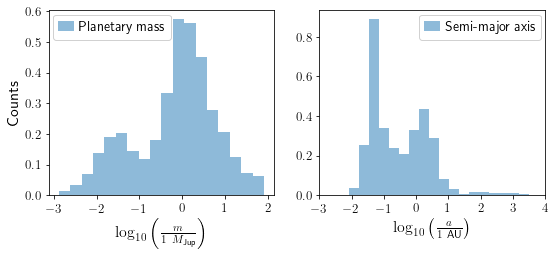

In [90]:
# -Plot----distributions 
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8.9, 3.4))
bins = 18

m=np.log10(data.mass.values)
a=np.log10(data.semi_major_axis.values)

ax1.hist(m, bins=bins, label=r'Planetary mass',
         color = "C0", alpha = .5, density= True)
ax2.hist(a, bins=bins, label=r'Semi-major axis', 
         color = "C0", alpha = .5, density= True)

ax1.set_xlabel(r"$\log_{10}\left(\frac{m}{1\ M_\text{Jup}}\right)$")
ax2.set_xlabel(r"$\log_{10}\left(\frac{a}{1\ \text{AU}}\right)$")
ax1.set_ylabel(r"Counts")

ax1.set_xticks(np.arange(int(min(m))-1, int(max(m))+2, 1.0))
ax2.set_xticks(np.arange(int(min(a))-1, int(max(a))+2, 1.0))


ax1.legend(handletextpad=.4, labelspacing=.25, loc=0)
ax2.legend(handletextpad=.4, labelspacing=.25, loc=0)
plt.savefig("figures/hists.pdf", bbox_inches='tight')

So, `data` is a DataFrame without NaN values in columns of names, masses, semi major axis and their uncertainties. Finally, we got 1217 rows, it means, exoplanets with confirmed data. 

## 2. Get the center of Mass 
We need to estimate the $r_\text{cm}$ for each system. The definition of center of mass:
\begin{equation*}
r_\text{cm} = \frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{\sum \limits_{k=1}^{n}m_{k}} %=\frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{M_{T}}
\end{equation*}
To do it, is nessesary get the values mass $m$ times disnace $r$, for each planet, so with the columns of `mass` and distance from the star `semi_major_axis` we can get $m_{k}\vec{r_{k}}$ values. Then, we take the sum for all planets in each systems, as a result we got $\text{CM}_i$ for $i\in\{0,1,2,3,4,\ldots,n\}$.

Our variable for clasify the systems is CM but some systems only have one planet, so, the center of mass for this systems CM$_j$, can be taked as the mass $m_j$.

**Remember:** The `data.groupby("key")` split the data in groups which are the key.

**Remember:** The `data[i].multiply(data[j])` multiplies the comun i and j of DataFrame or Series i and j, row by row.

**Remember:** The `data.groupby.groups.keys()` get the keys of the split data.

In [83]:
# Group by the name system:
p_system = data.groupby("star_name")
print('The number of planetary systems = '+ str(len(p_system)))

# The numer of exoplanets around each star:
number=(data["star_name"].value_counts()).to_frame()

# The number of systems with more than one exoplanet:
count = 0
for i, index in enumerate(number.star_name.values):
    if index>1.:
        count+=1 
print("Systems with more than one planet = "+str(count))

The number of planetary systems = 980
Systems with more than one planet = 153


In [84]:
#-----------------------function center of mass-----------------------
#it returns a data frame group bay systems:

def CoM(data): #data is a dataframe with mass and semi major axis 
    
    # Multiplications between columns mass and axis, CM_i new column:
    data = data.assign(CM_i=data["semi_major_axis"]*data["mass"])
    #print(data)
    # Group by each planet in the system:
    p_system = data.groupby("star_name") 
    system = list(p_system.groups.keys())
    # Total mass per system:
    M_total = p_system["mass"].sum()
    sum_rm = p_system['CM_i'].sum() # sum of masses in each system.
    # Center of mass:
    CoM = sum_rm.divide(M_total)
    
    system = list(p_system.groups.keys())
    
    NewData = pd.DataFrame({'System_name':system,
                            'Total_mass':M_total.tolist(),
                            'Center_of_Mass':CoM.tolist()})

    return NewData

In [85]:
CoM=CoM(data);#CoM

Therefore, the distribution of the $r_\text{cm}$

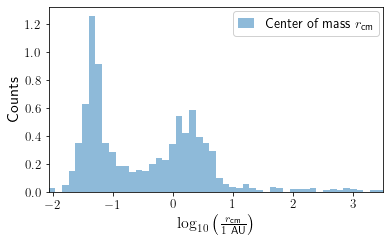

In [101]:
#histogram 
x=CoM.Center_of_Mass.values

fig, ax = plt.subplots(1, 1, figsize=(6, 3.4))

ax.hist(np.log10(x), bins=50, label=r"Center of mass $r_\text{cm}$", 
        alpha=.5, density=True)
#ax.set_xticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$',
#                    r'$10^{1}$',r'$10^{2}$',r'$10^{3}$'])#,
#                    r'$10^{3}$',r'$10^{4}$'])
ax.set(xlim=(np.log10(x).min(),np.log10(x).max()))

plt.xlabel(r"$\log_{10}\left(\frac{r_\text{cm}}{1\ \text{AU}}\right)$")
plt.ylabel(r"Counts")
plt.legend()
plt.savefig("figures/CMhist.pdf",bbox_inches='tight')

However, the calculus of the $r_\text{cm}$, was made without take into account the mass of the star.

## 3. Gaussian Mixture Model

At first we will use the Gaussian Mixture Model to clasify the $r_\text{cm}$ in $n$ finite distributions. Python has the library `sckit-learn`, which uses the Expectation Maximization algorithm to determine the maximum likelihood for  a determined number $n$ of clusters (more informtion  <a href="https://scikit-learn.org/stable/modules/mixture.html">Gaussian Mixture</a>). 


### Class: clustering

This class is oriented to determine the ideal number of cluster for some data. In this case de data came from a DataFrame `CoM`, which has the center of mass $r_\text{cm}$ for each observed planetary system.

In [11]:
# data is a clean DataFrame with the previous Nan values deleteed.
# log is True of False depending if you take the log10 of the variables.  

class clustering(object):
    
    def __init__(self, data, log):  

        data = data.assign(CM_i=data["semi_major_axis"]*data["mass"])
        self.p_system = data.groupby("star_name") 
        self.log = log
        
        if log==True:
            self.r_cm=np.reshape(np.log10(self.CoM().Center_of_Mass.values),(-1,1))
            self.name=r'$\log_{10}(r_\text{cm})$ [AU]'
        else: 
            self.r_cm=np.reshape(self.CoM().Center_of_Mass.values,(-1,1))
            self.name=r'$r_\text{cm}$ [AU]'
    
    def CoM(self):
        CoM = self.p_system['CM_i'].sum().divide(self.p_system["mass"].sum())
        self.NewData = pd.DataFrame({'System_name':list(self.p_system.groups.keys()),
                                    'Total_mass':self.p_system["mass"].sum().tolist(),
                                    'Center_of_Mass':CoM.tolist()})
        return self.NewData
        
    def GMM(self, n_components):
        self.n = n_components
        self.gmm = GaussianMixture(self.n, covariance_type='full', random_state=0)
        self.gmm.fit(self.r_cm)
        self.cluster_label = self.gmm.predict(self.r_cm)
        
    def inf_criteria(self, times):
        self.bic, self.aic = [], []
        for i in range(times):
            i += 1
            self.GMM(i)
            self.bic.append(self.gmm.bic(self.r_cm)); self.aic.append(self.gmm.aic(self.r_cm))
        
        self.ideal = self.bic.index(min(self.bic))+1
        
        print('Ideal number of clusters, BIC = '+str(self.bic.index(min(self.bic))+1))
        print('Ideal number of clusters, AIC = '+str(self.aic.index(min(self.aic))+1))

### Method: Center of Mass ... again
The  `clustering` class has a method for obtain the center of mas $r_\text{cm}$

In [12]:
cluster = clustering(data, True)
#data.head()
cluster.CoM()

,System_name,Total_mass,Center_of_Mass
0,OGLE-2016-BLG-1067L,0.43000,1.700000
1,11 Oph,21.00000,243.000000
2,1RXS J235133.3+312720,32.00000,120.000000
3,2M 1938+46,1.90000,0.920000
4,2M 0122-24,20.00000,52.000000
...,...,...,...
821,gamma Cephei,11.09000,2.050000
822,kappa And,13.00000,100.000000
823,pi Men,13.02517,3.304225
824,ups And,0.62000,0.059000


### Method: GMM for gaussian mixture model
We use the `GaussianMixture` package from `sckit-learn` to classify our data in different number of clusrers ($n$). Here, we employ the number of compnents, `n_components` as the numer of clusters $n$. The `GaussianMixture` let us predict the labels of clustering for data samples, using trained model. 

Finally the `GaussianMixture` also has the predict posterior probability of each component given the data (more informtion  <a href="https://scikit-learn.org/stable/modules/mixture.html">Gaussian Mixture</a>). 

In [13]:
cluster = clustering(data, True)
cluster.GMM(10)
#cluster.cluster_label

### Method: Information Criterion AIC/BIC
Now, we need to determine the idel number of clusters. To do that, we use the information criterion as strategy to avoiding underfit or overfit. The information criteria determine the quality of models and score them (more information <a href="https://en.wikipedia.org/wiki/Model_selection#Criteria">Model selection</a>).  


We define a function wich gets the information criteria for different numbers of components (the number of mixture components $n$), in order to obtain the minimum value of criterium to determine the ideal number of clsuters. The lowest BIC/AIC is preferred.

Then, it plots the BIC and AIC values to observe their behavior.

cluster = clustering(data, True)
cluster.inf_criteria(20)

## 4. Confidence of classification 

Now we employ a inherited class in python fo the class `clustering`.


### Class: draw - synthetic $r_\text{cm}$


This function generates 1000 synthetic systems ( _Dawns_ ) per each data (the mass an its uncertainty). We take draws from this, and stimate the validation of the classification.

The posteriror probabilities are determinated by the function `gmm.predict()`

In [14]:
class draw(clustering):
    
    def __init__(self, data, log):
        clustering.__init__(self, data, log)
    
    def draws(self):
        
        self.Draws = [] # a 1000 synthetic r_cm for each system
        
        for sistem in self.p_system.groups.keys():
            
            SystemA_i = data[data.star_name == sistem]  
            Mass_System, Mass_Axe, DrawsAA  = np.zeros(1000), np.zeros(1000), np.zeros(1000)
            
            for planet in range(len(SystemA_i)):
                
                mu_m, sigma_m = SystemA_i.mass.values[planet], SystemA_i.mass_error_min.values[planet]
                mu_a, sigma_a = SystemA_i.semi_major_axis.values[planet], SystemA_i.semi_major_axis_error_min.values[planet]
                
                lower_m, upper_m = 0, mu_m+5*sigma_m 
                lower_a, upper_a = 0, mu_a+5*sigma_a
                
                a_m, b_m = (lower_m - mu_m) / sigma_m, (upper_m - mu_m) / sigma_m
                a_a, b_a = (lower_a - mu_a) / sigma_a, (upper_a - mu_a) / sigma_a
                
                masses = truncnorm.rvs(a_m, b_m, scale=sigma_m, loc=mu_m, size=1000)
                axes   = truncnorm.rvs(a_a, b_a, scale=sigma_a, loc=mu_a, size=1000)

                Mass_Axe += masses*axes
                Mass_System += masses
    
                DrawsAA+=Mass_Axe/Mass_System
        
            self.Draws.append(DrawsAA)
        
    def fraction_ch(self,  r = 15):
        r = 10
        
        frac=[]
        self.draws()
        self.inf_criteria(r)
        self.GMM(self.ideal)
        
        if self.log == True:  
            Dr = np.log10(self.Draws)
            
        for k in range(len(Dr)):
            Draw_i=Dr[k][:,np.newaxis]
            frac+=[(self.cluster_label[k]!=self.gmm.predict(Draw_i)).sum()/len(Dr)] # AA es el elemento i de draws (que debe ser un array de 1000 elementos)
            p = sum(frac)/len(frac)*100
            
        return print("the persentage of change is "+str('%.2f' % p))


### Method: draws

So, the daws came from the class `draw` with the method `draws` and generates $1000$ synthetic values for each observable value in the center of mass the $r_ \text{cm}$

In [15]:
ss = draw(data, False)
ss.draws()
#plt.hist(ss.Draws[8])
#ss.fraction_ch()

### Method: fraction_ch

It gets the percentage of values that changes of cluster, in order to verify how reliable the classification is.

In [16]:
ss = draw(data, True)
ss.fraction_ch()

Ideal number of clusters, BIC = 3
Ideal number of clusters, AIC = 8
the persentage of change is 4.13


In [17]:
# CM_log is the centero of mass in log scale for each system
orig = clustering(data, True)
orig.GMM(4)
Draws = ss.Draws

frac=[]
for k in range(len(Draws)):
    Draw_i=np.log10(Draws[k][:,np.newaxis])
    frac+=[(orig.cluster_label[k]!=orig.gmm.predict(Draw_i)).sum()/10] # AA es el elemento i de draws (que debe ser un array de 1000 elementos)

sum(frac)/len(frac) #in percentage

4.921307506053269

In [18]:
"""
    #Clusters_plot
    def clusters_plot(self, save=False, fig_name="nn"):
        self.fig_name = fig_name
        dsize, lsize, fsize = 3.5, 11, 14
        self.color = ["C"+str(self.cluster_label[i]+1) for i in range(len(self.cluster_label))]
        x = np.linspace(self.data.min(),self.data.max(),1000)
        figure, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12, 5))
        
        #Gaussians and scaters:
        for c in range(self.n):
            ax[0].plot(x,norm.pdf(x,self.gmm.means_[c], self.gmm.covariances_[c])[0]/\
                       norm.pdf(x,self.gmm.means_[c], self.gmm.covariances_[c])[0].max(), 
                      label =r"Gaussian "+str(c+1))
            
            Mass_a=self.data[self.cluster_label==c]    
            
            ax[0].plot(Mass_a, np.zeros(len(Mass_a)),"o", markersize=dsize,
                       label='Cluster '+str(c+1), color="C"+str(c))

            ax[1].plot(self.data,self.gmm.predict_proba(self.data)[:,c],"o",
                       markersize=dsize, label="Cluster "+str(c+1))
            
        ax[0].set(ylabel=r'Normal distribution', xlabel=self.name)
        ax[1].set(ylabel=r'Posterior probabilities',  xlabel=self.name)

        ax[0].legend(bbox_to_anchor=(0,1.02,1,0.2),loc="lower left", handletextpad=.01,
                     edgecolor='black', mode="expand", ncol=self.n, fontsize=lsize)
        ax[1].legend(bbox_to_anchor=(0,1.02,1,0.2),loc="lower left", 
                     mode="expand", ncol=self.n, fontsize=lsize, edgecolor='black') 
        
        plt.rcParams.update({'font.size': fsize})
        plt.subplots_adjust(wspace = .2)
        
        if save == True: 
            plt.savefig("figures/"+self.fig_name+".pdf" ,bbox_inches='tight')
"""

'\n    #Clusters_plot\n    def clusters_plot(self, save=False, fig_name="nn"):\n        self.fig_name = fig_name\n        dsize, lsize, fsize = 3.5, 11, 14\n        self.color = ["C"+str(self.cluster_label[i]+1) for i in range(len(self.cluster_label))]\n        x = np.linspace(self.data.min(),self.data.max(),1000)\n        figure, ax = plt.subplots(1, 2, sharex=\'col\', sharey=\'row\', figsize=(12, 5))\n        \n        #Gaussians and scaters:\n        for c in range(self.n):\n            ax[0].plot(x,norm.pdf(x,self.gmm.means_[c], self.gmm.covariances_[c])[0]/                       norm.pdf(x,self.gmm.means_[c], self.gmm.covariances_[c])[0].max(), \n                      label =r"Gaussian "+str(c+1))\n            \n            Mass_a=self.data[self.cluster_label==c]    \n            \n            ax[0].plot(Mass_a, np.zeros(len(Mass_a)),"o", markersize=dsize,\n                       label=\'Cluster \'+str(c+1), color="C"+str(c))\n\n            ax[1].plot(self.data,self.gmm.predict_pr

In [19]:
"""#comparison between AIC and BIC criteria----------------(plot)------------------------

def plot_criteria(criteria):
  
    figure, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(9, 4))
    let   = 15 
    label = ['BIC','AIC']

    for i,criterium in enumerate(criteria):
        dim  = len(criteria[i])
        norm = min(criteria[i])/max(criteria[i])
        
        ax[i].plot(range(1, dim+1), criteria[i]/max(criteria[i]), "o",
                   c="C1",label=label[i]+" values")
        ax[i].plot(range(1, dim+1),criteria[i]/max(criteria[i]))#, label=label[i])
        ax[i].plot(range(1, dim+1),np.ones(dim)*norm,
                   "--",label=r"Ideal clusters "+str(criteria[i].index(min(criteria[i]))+1) )

        ax[i].set_xlabel(r'Number of clusters', fontsize=let+1)
        ax[i].legend(fontsize=let, loc=1,edgecolor='black')
        ax[i].set_xlim(0, dim+1)
        ax[i].set_xticks(np.arange(0, dim, step=2))
        ax[i].tick_params(labelsize=let)

    ax[0].set_ylabel(r'Criterium value normalized', fontsize=let+1)
    return [bic,aic]"""

'#comparison between AIC and BIC criteria----------------(plot)------------------------\n\ndef plot_criteria(criteria):\n  \n    figure, ax = plt.subplots(1, 2, sharex=\'col\', sharey=\'row\', figsize=(9, 4))\n    let   = 15 \n    label = [\'BIC\',\'AIC\']\n\n    for i,criterium in enumerate(criteria):\n        dim  = len(criteria[i])\n        norm = min(criteria[i])/max(criteria[i])\n        \n        ax[i].plot(range(1, dim+1), criteria[i]/max(criteria[i]), "o",\n                   c="C1",label=label[i]+" values")\n        ax[i].plot(range(1, dim+1),criteria[i]/max(criteria[i]))#, label=label[i])\n        ax[i].plot(range(1, dim+1),np.ones(dim)*norm,\n                   "--",label=r"Ideal clusters "+str(criteria[i].index(min(criteria[i]))+1) )\n\n        ax[i].set_xlabel(r\'Number of clusters\', fontsize=let+1)\n        ax[i].legend(fontsize=let, loc=1,edgecolor=\'black\')\n        ax[i].set_xlim(0, dim+1)\n        ax[i].set_xticks(np.arange(0, dim, step=2))\n        ax[i].tick_param